### Neural ODE for Collision-Coalescence Parameterization

Plans:
- ODEFunc: 4 → 50 (Tanh) → 50 (Tanh) → 50 (Tanh) → 4 (linear)
- Solver: RK4 fixed-step (dt=20s)
- Training: Multi-step prediction over 55 timesteps (1100 seconds)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Hyperparameters
config = {
    'n_timesteps': 55,           # Truncate trajectories to first 55 steps
    'dt': 20.0,                  # Time step in seconds
    'hidden_size': 50,           # Neurons per hidden layer
    'n_layers': 3,               # Number of hidden layers
    'batch_size': 4,             # Trajectories per batch
    'learning_rate': 1e-3,       # Adam learning rate
    'n_epochs': 100,             # Training epochs
    'val_every': 5,              # Validation frequency
}

# Data paths
data_dir = Path('data')
train_path = data_dir / 'train_trajectories.pkl'
val_path = data_dir / 'val_trajectories.pkl'
stats_path = data_dir / 'moment_normalization_stats.pkl'

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  n_timesteps: 55
  dt: 20.0
  hidden_size: 50
  n_layers: 3
  batch_size: 4
  learning_rate: 0.001
  n_epochs: 100
  val_every: 5


In [3]:
# Load preprocessed trajectories
with open(train_path, 'rb') as f:
    train_trajectories = pickle.load(f)

with open(val_path, 'rb') as f:
    val_trajectories = pickle.load(f)

with open(stats_path, 'rb') as f:
    norm_stats = pickle.load(f)

print(f"\nLoaded {len(train_trajectories)} training trajectories")
print(f"Loaded {len(val_trajectories)} validation trajectories")
print(f"\nNormalization stats loaded: {list(norm_stats.keys())}")

# Inspect sample trajectory
sample_traj = train_trajectories[0]
print(f"\nSample trajectory keys: {list(sample_traj.keys())}")
print(f"Moments shape: {sample_traj['moments_scaled'].shape}")
print(f"Trajectory length: {sample_traj['length']}")


Loaded 90 training trajectories
Loaded 10 validation trajectories

Normalization stats loaded: ['asinh_scales', 'moment_scaler_mean', 'moment_scaler_std', 'moment_scaler']

Sample trajectory keys: ['moments', 'length', 'ic_idx', 'moments_scaled']
Moments shape: (130, 4)
Trajectory length: 130


In [4]:
class TrajectoryDataset(Dataset):
    """Dataset for trajectory prediction.
    
    Returns:
        initial_state: (4,) tensor - Initial moment values
        trajectory: (n_timesteps, 4) tensor - Full trajectory including initial state
    """
    
    def __init__(self, trajectories, n_timesteps=55):
        """
        Args:
            trajectories: List of trajectory dictionaries
            n_timesteps: Number of timesteps to use (truncate to this length)
        """
        self.trajectories = trajectories
        self.n_timesteps = n_timesteps
        
        # Filter out trajectories that are too short
        self.valid_indices = [
            i for i, traj in enumerate(trajectories)
            if traj['length'] >= n_timesteps
        ]
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Get the valid trajectory
        traj_idx = self.valid_indices[idx]
        traj = self.trajectories[traj_idx]
        
        # Extract first n_timesteps
        moments_scaled = traj['moments_scaled'][:self.n_timesteps]  # (n_timesteps, 4)
        
        # Initial state
        initial_state = moments_scaled[0]  # (4,)
        
        # Full trajectory
        trajectory = moments_scaled  # (n_timesteps, 4)
        
        return (
            torch.tensor(initial_state, dtype=torch.float32),
            torch.tensor(trajectory, dtype=torch.float32)
        )

# Create datasets
train_dataset = TrajectoryDataset(train_trajectories, n_timesteps=config['n_timesteps'])
val_dataset = TrajectoryDataset(val_trajectories, n_timesteps=config['n_timesteps'])

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False
)

In [5]:
class ODEFunc(nn.Module):
    """Neural network that defines the derivative function dM/dt = f(M).
    
    Architecture: 4 → 50(Tanh) → 50(Tanh) → 50(Tanh) → 4(linear)
    """
    
    def __init__(self, hidden_size=50, n_layers=3):
        super(ODEFunc, self).__init__()
        
        layers = []
        
        # Input layer: 4 moments → hidden_size
        layers.append(nn.Linear(4, hidden_size))
        layers.append(nn.Tanh())
        
        # Hidden layers: hidden_size → hidden_size
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        
        # Output layer: hidden_size → 4 derivatives
        layers.append(nn.Linear(hidden_size, 4))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, y):
        """
        Args:
            t: Scalar time (required by odeint, but not used for time-invariant dynamics)
            y: State tensor of shape (batch_size, 4)
        
        Returns:
            dy/dt: Derivative tensor of shape (batch_size, 4)
        """
        return self.net(y)


class NeuralODE(nn.Module):
    """Wrapper class that integrates the ODE using torchdiffeq."""
    
    def __init__(self, ode_func, method='rk4'):
        """
        Args:
            ode_func: ODEFunc instance
            method: ODE solver method (default: 'rk4')
        """
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func
        self.method = method
    
    def forward(self, initial_state, t_span):
        """
        Args:
            initial_state: Tensor of shape (batch_size, 4)
            t_span: Tensor of time points to evaluate, shape (n_timesteps,)
        
        Returns:
            trajectory: Tensor of shape (n_timesteps, batch_size, 4)
        """
        trajectory = odeint(
            self.ode_func,
            initial_state,
            t_span,
            method=self.method
        )
        return trajectory


# Initialize model
ode_func = ODEFunc(hidden_size=config['hidden_size'], n_layers=config['n_layers']).to(device)
model = NeuralODE(ode_func, method='rk4').to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel initialized with {n_params:,} trainable parameters")
print(model.ode_func.net)


Model initialized with 5,554 trainable parameters
Sequential(
  (0): Linear(in_features=4, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=4, bias=True)
)


In [6]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Time points for integration
t_span = torch.arange(0, config['n_timesteps']) * config['dt']  # [0, 20, 40, ..., 1080]
t_span = t_span.to(device)

print(f"Integration time points: {t_span[:5].cpu().numpy()}...{t_span[-3:].cpu().numpy()} seconds")
print(f"Total integration time: {t_span[-1].item()} seconds ({config['n_timesteps']} steps)")

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'epochs': []
}

Integration time points: [ 0. 20. 40. 60. 80.]...[1040. 1060. 1080.] seconds
Total integration time: 1080.0 seconds (55 steps)


In [7]:
def train_epoch(model, train_loader, optimizer, criterion, t_span, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    
    for initial_state, target_trajectory in tqdm(train_loader, desc='Training', leave=False):
        initial_state = initial_state.to(device)  # (batch_size, 4)
        target_trajectory = target_trajectory.to(device)  # (batch_size, n_timesteps, 4)
        
        # Forward pass: integrate ODE
        pred_trajectory = model(initial_state, t_span)  # (n_timesteps, batch_size, 4)
        
        # Reshape for loss computation: (n_timesteps, batch_size, 4) -> (batch_size, n_timesteps, 4)
        pred_trajectory = pred_trajectory.permute(1, 0, 2)
        
        # Compute loss over entire trajectory
        loss = criterion(pred_trajectory, target_trajectory)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def validate(model, val_loader, criterion, t_span, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for initial_state, target_trajectory in val_loader:
            initial_state = initial_state.to(device)
            target_trajectory = target_trajectory.to(device)
            
            # Forward pass
            pred_trajectory = model(initial_state, t_span)
            pred_trajectory = pred_trajectory.permute(1, 0, 2)
            
            # Compute loss
            loss = criterion(pred_trajectory, target_trajectory)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss


# Training loop
best_val_loss = float('inf')
print("\nStarting training...\n")

for epoch in range(config['n_epochs']):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, t_span, device)
    
    # Validate
    if (epoch + 1) % config['val_every'] == 0:
        val_loss = validate(model, val_loader, criterion, t_span, device)
        history['val_loss'].append(val_loss)
        history['epochs'].append(epoch + 1)
        
        print(f"Epoch {epoch+1}/{config['n_epochs']} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'config': config
            }, 'best_model.pt')
            print(f"  → Saved best model (val_loss: {val_loss:.6f})")
    else:
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config['n_epochs']} - Train Loss: {train_loss:.6f}")
    
    history['train_loss'].append(train_loss)

print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")


Starting training...



Epoch 5/100 - Train Loss: 2.146964, Val Loss: 1.974199
  → Saved best model (val_loss: 1.974199)


Epoch 10/100 - Train Loss: 1.569392, Val Loss: 1.455072
  → Saved best model (val_loss: 1.455072)


Epoch 15/100 - Train Loss: 1.252299, Val Loss: 1.151827
  → Saved best model (val_loss: 1.151827)


Epoch 20/100 - Train Loss: 1.024296, Val Loss: 0.931090
  → Saved best model (val_loss: 0.931090)


Epoch 25/100 - Train Loss: 0.842638, Val Loss: 0.758856
  → Saved best model (val_loss: 0.758856)


Epoch 30/100 - Train Loss: 0.691652, Val Loss: 0.624404
  → Saved best model (val_loss: 0.624404)


Epoch 35/100 - Train Loss: 0.575043, Val Loss: 0.524765
  → Saved best model (val_loss: 0.524765)


Epoch 40/100 - Train Loss: 0.492323, Val Loss: 0.419676
  → Saved best model (val_loss: 0.419676)


Epoch 45/100 - Train Loss: 0.426079, Val Loss: 0.347703
  → Saved best model (val_loss: 0.347703)


Epoch 50/100 - Train Loss: 0.391787, Val Loss: 0.317962
  → Saved best model (val_loss: 0.317962)


Epoch 55/100 - Train Loss: 0.370635, Val Loss: 0.306730
  → Saved best model (val_loss: 0.306730)


Epoch 60/100 - Train Loss: 0.351645, Val Loss: 0.295758
  → Saved best model (val_loss: 0.295758)


Epoch 65/100 - Train Loss: 0.339173, Val Loss: 0.288997
  → Saved best model (val_loss: 0.288997)


Epoch 70/100 - Train Loss: 0.321054, Val Loss: 0.285176
  → Saved best model (val_loss: 0.285176)


Epoch 75/100 - Train Loss: 0.318203, Val Loss: 0.282945
  → Saved best model (val_loss: 0.282945)


Epoch 80/100 - Train Loss: 0.317827, Val Loss: 0.281435
  → Saved best model (val_loss: 0.281435)


Epoch 85/100 - Train Loss: 0.319115, Val Loss: 0.280599
  → Saved best model (val_loss: 0.280599)


Epoch 90/100 - Train Loss: 0.311072, Val Loss: 0.280065
  → Saved best model (val_loss: 0.280065)


Epoch 95/100 - Train Loss: 0.301101, Val Loss: 0.279712
  → Saved best model (val_loss: 0.279712)


Epoch 100/100 - Train Loss: 0.308666, Val Loss: 0.279607
  → Saved best model (val_loss: 0.279607)

Training complete! Best validation loss: 0.279607


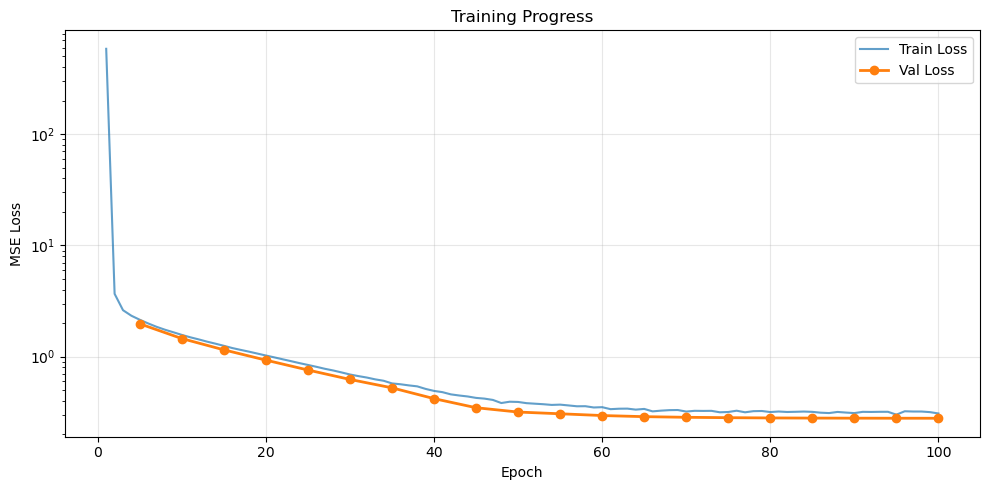

Final train loss: 0.308666
Final val loss: 0.279607
Best val loss: 0.279607


In [8]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

# Train loss
ax.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 
        label='Train Loss', alpha=0.7)

# Val loss
ax.plot(history['epochs'], history['val_loss'], 
        label='Val Loss', marker='o', linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Final train loss: {history['train_loss'][-1]:.6f}")
print(f"Final val loss: {history['val_loss'][-1]:.6f}")
print(f"Best val loss: {best_val_loss:.6f}")

In [9]:
# Load best model checkpoint
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.6f})")

Loaded best model from epoch 100 (val_loss: 0.279607)


/tmp/ipykernel_3147/142137649.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pt')


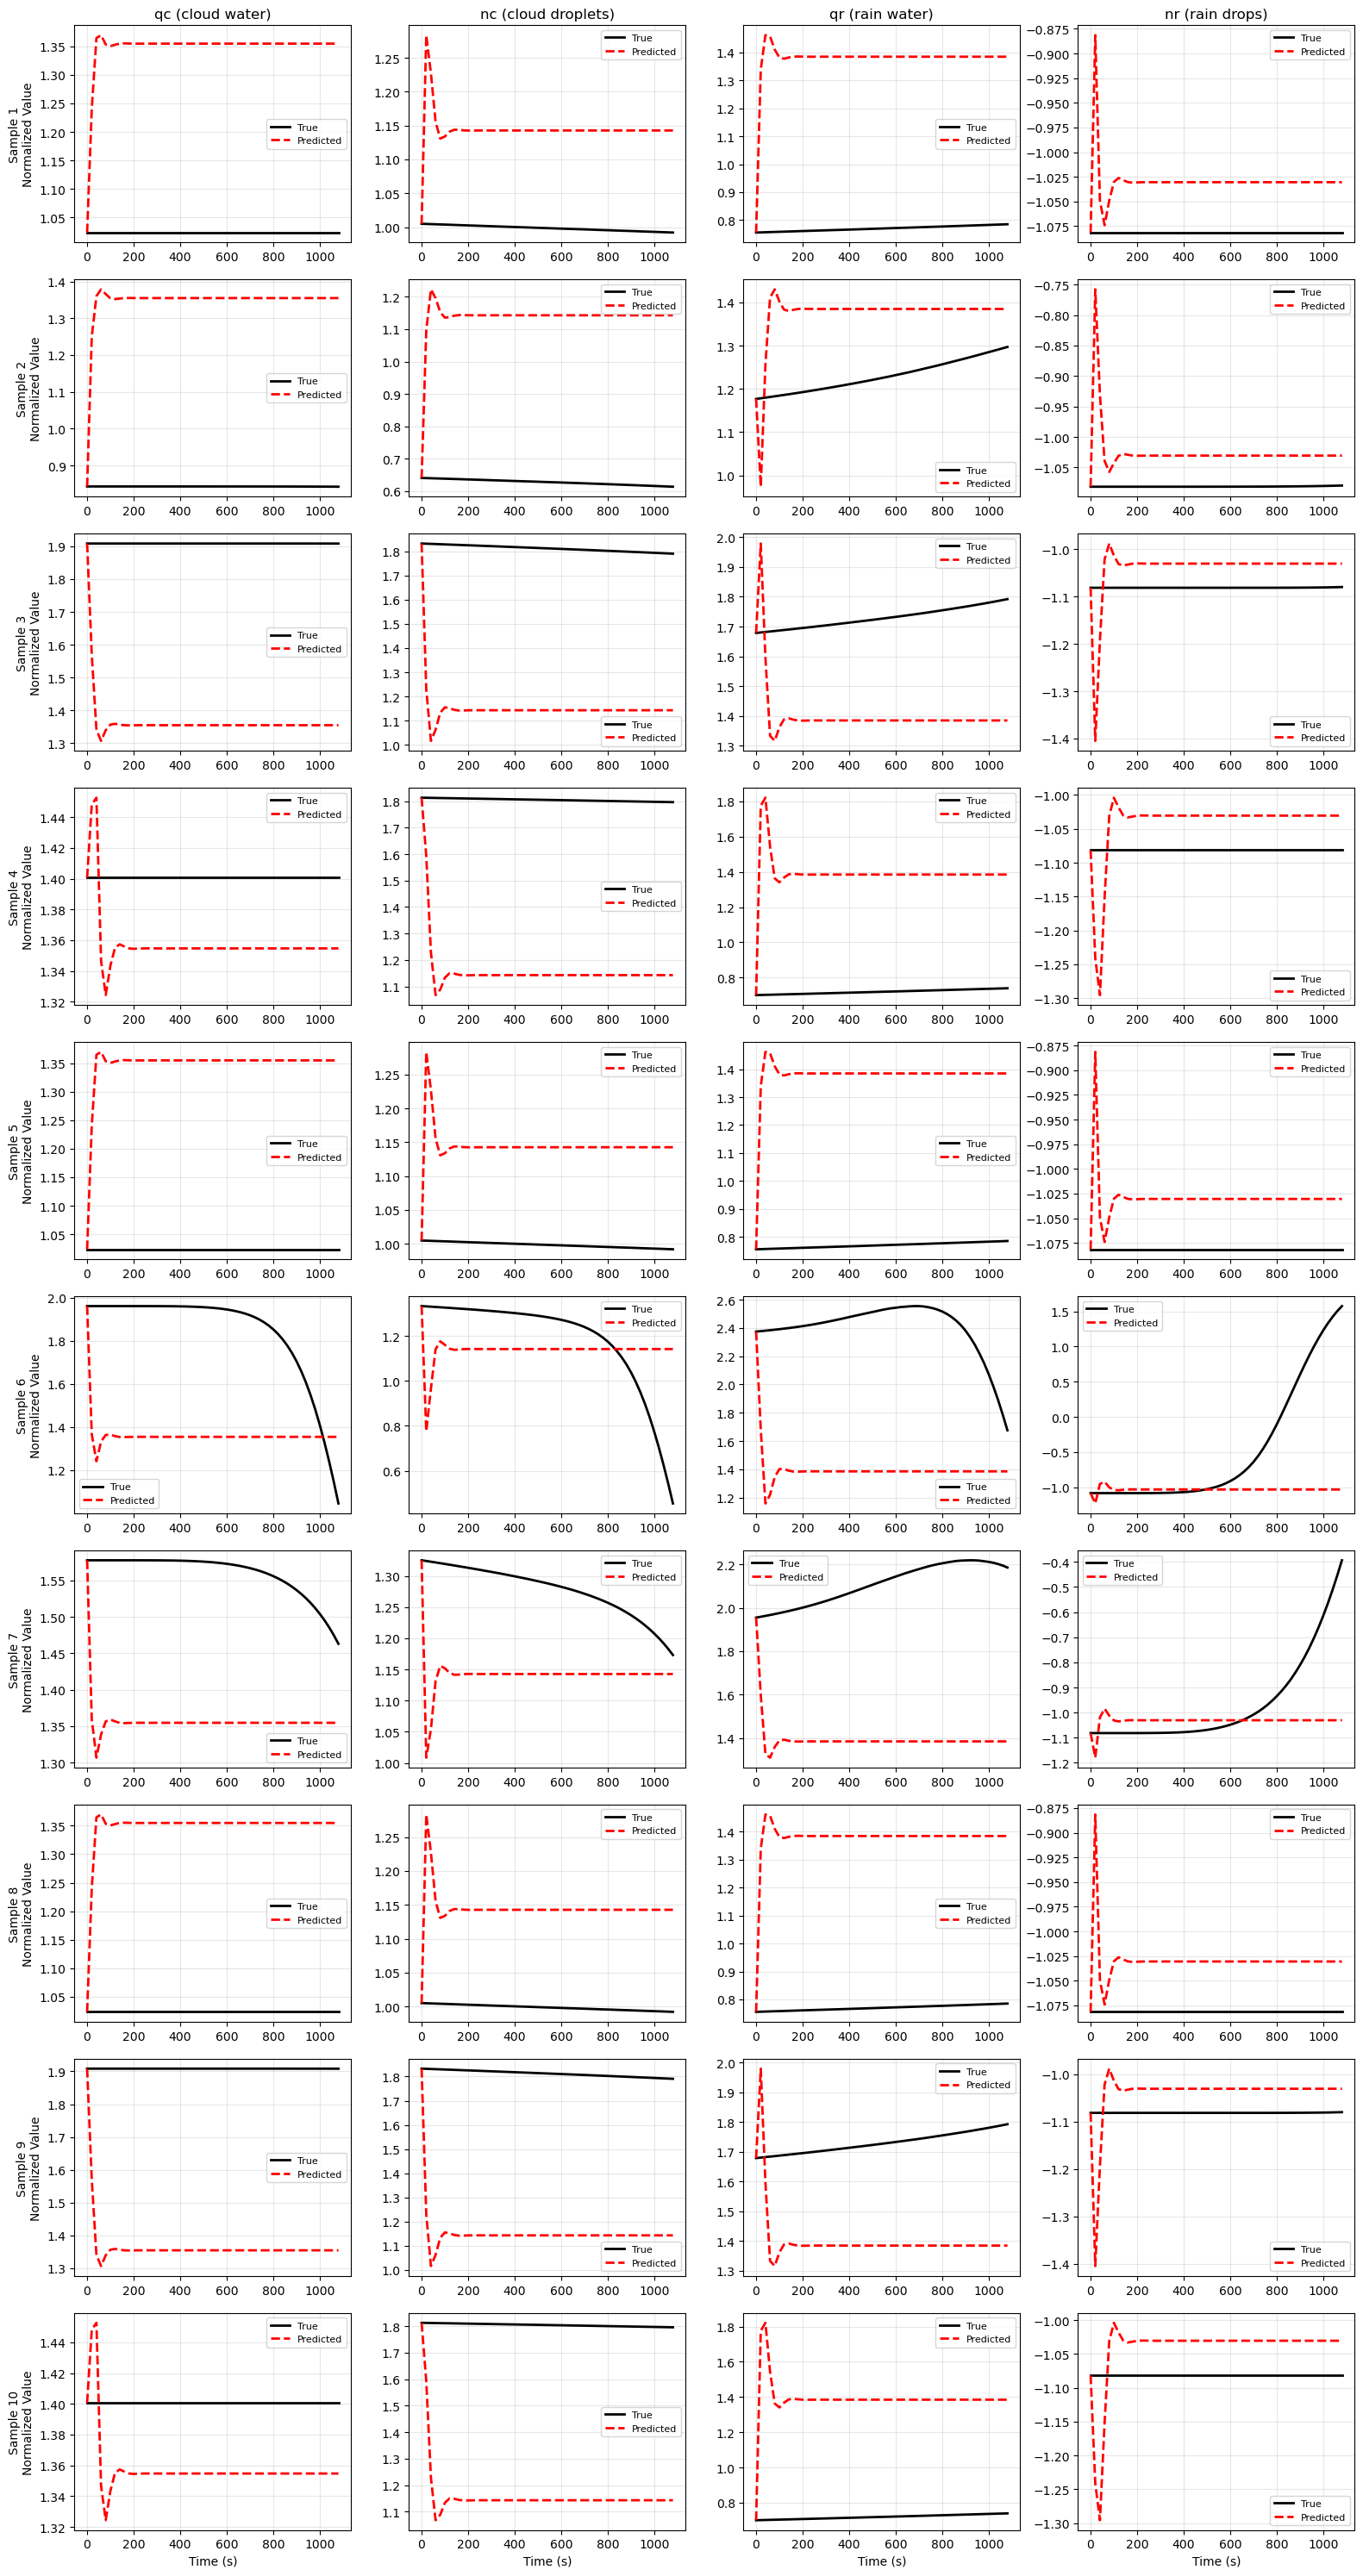

In [10]:
# Select validation samples to visualize
n_samples = 10
sample_indices = np.random.choice(len(val_dataset), n_samples, replace=True)

# Moment names
moment_names = ['qc (cloud water)', 'nc (cloud droplets)', 'qr (rain water)', 'nr (rain drops)']

# Create subplots
fig, axes = plt.subplots(n_samples, 4, figsize=(16, 3*n_samples))
if n_samples == 1:
    axes = axes[np.newaxis, :]

with torch.no_grad():
    for i, sample_idx in enumerate(sample_indices):
        # Get data
        initial_state, target_trajectory = val_dataset[sample_idx]
        initial_state = initial_state.unsqueeze(0).to(device)  # (1, 4)
        target_trajectory = target_trajectory.cpu().numpy()  # (55, 4)
        
        # Predict
        pred_trajectory = model(initial_state, t_span)  # (55, 1, 4)
        pred_trajectory = pred_trajectory.squeeze(1).cpu().numpy()  # (55, 4)
        
        # Time axis
        time_axis = t_span.cpu().numpy()
        
        # Plot each moment
        for j in range(4):
            ax = axes[i, j]
            ax.plot(time_axis, target_trajectory[:, j], 'k-', label='True', linewidth=2)
            ax.plot(time_axis, pred_trajectory[:, j], 'r--', label='Predicted', linewidth=2)
            
            if i == 0:
                ax.set_title(moment_names[j], fontsize=12)
            if i == n_samples - 1:
                ax.set_xlabel('Time (s)', fontsize=10)
            if j == 0:
                ax.set_ylabel(f'Sample {i+1}\nNormalized Value', fontsize=10)
            
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Compute metrics on full validation set
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for initial_state, target_trajectory in val_loader:
        initial_state = initial_state.to(device)
        
        # Predict
        pred_trajectory = model(initial_state, t_span)  # (n_timesteps, batch_size, 4)
        pred_trajectory = pred_trajectory.permute(1, 0, 2)  # (batch_size, n_timesteps, 4)
        
        all_predictions.append(pred_trajectory.cpu().numpy())
        all_targets.append(target_trajectory.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)  # (n_samples, n_timesteps, 4)
all_targets = np.concatenate(all_targets, axis=0)  # (n_samples, n_timesteps, 4)

# Compute metrics per moment
print("\nValidation Metrics (normalized space):")

for i, name in enumerate(moment_names):
    # MSE
    mse = np.mean((all_predictions[:, :, i] - all_targets[:, :, i]) ** 2)
    
    # MAE
    mae = np.mean(np.abs(all_predictions[:, :, i] - all_targets[:, :, i]))
    
    # R² score
    ss_res = np.sum((all_targets[:, :, i] - all_predictions[:, :, i]) ** 2)
    ss_tot = np.sum((all_targets[:, :, i] - np.mean(all_targets[:, :, i])) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print(f"{name:25s} - MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")

# Overall metrics
overall_mse = np.mean((all_predictions - all_targets) ** 2)
overall_mae = np.mean(np.abs(all_predictions - all_targets))
print(f"{'Overall':25s} - MSE: {overall_mse:.6f}, MAE: {overall_mae:.6f}")


Validation Metrics (normalized space):
qc (cloud water)          - MSE: 0.109420, MAE: 0.265774, R²: 0.299784
nc (cloud droplets)       - MSE: 0.176105, MAE: 0.334178, R²: -0.008223
qr (rain water)           - MSE: 0.638068, MAE: 0.656801, R²: -0.259011
nr (rain drops)           - MSE: 0.112153, MAE: 0.117458, R²: -0.019150
Overall                   - MSE: 0.258937, MAE: 0.343553


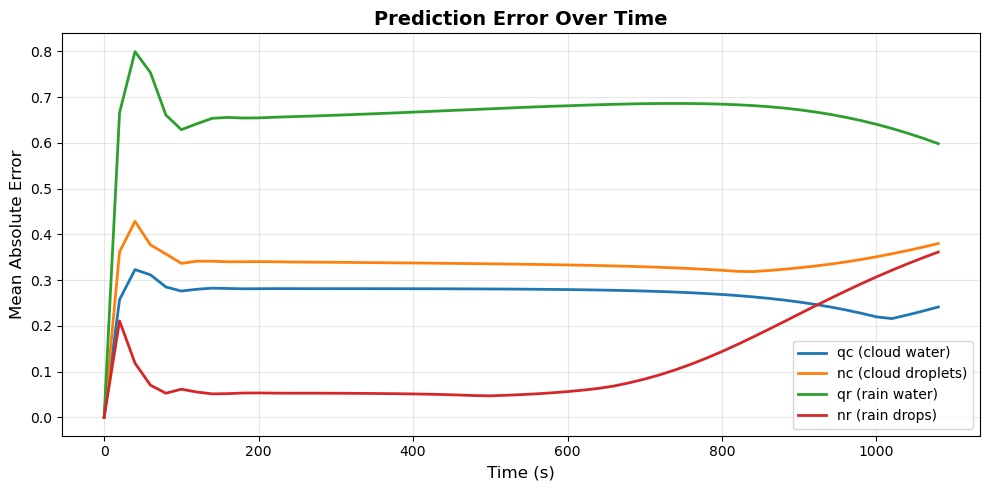

In [12]:
# Compute MAE as a function of time
mae_over_time = np.mean(np.abs(all_predictions - all_targets), axis=0)  # (n_timesteps, 4)
time_axis = t_span.cpu().numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

for i, name in enumerate(moment_names):
    ax.plot(time_axis, mae_over_time[:, i], label=name, linewidth=2)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Prediction Error Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()